## Regression Analysis on Australia's Current  House Price Listing Data

Name : Karishma Saikia


### BACKGROUND

This is a house price listing data of Australia

**Column list:**

* neighbourhood_cleansed -information on the neighborhood.
* property_type - The type of property that is being listed.
* room_type - The type of room that is available for rent
* bathrooms - The count of bathrooms available (e.g., 1, 2, 1.5).  
* bedrooms - The count of bedrooms available (e.g., 0, 1, 2).
* beds - The count of beds available in the rental (e.g., 0, 1, 2).
* price - The cost of the rental per night in USD.
* square_meters - area of the room

### PROBLEM STATEMENT

How well the features in the dataset can predict the prices of houses in different areas of Australia?

Imported the necessary packages

In [922]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge

from pylab import rcParams
rcParams['figure.figsize'] = 10,6
plt.rcParams.update({'font.size': 18});

In [757]:
raw_data=pd.read_csv('Australia_listings.csv')

In [758]:
raw_data.head(2)

,id,country,state,neighbourhood_cleansed,property_type,square_meters,price,room_type,bathrooms,bedrooms,beds
0,3363954,Australia,NSW,BALLINA SHIRE COUNCIL,House,0.00,"$2,900.00",Entire home/apt,3.0,4.0,4.0
1,13048065,Australia,NSW,BALLINA SHIRE COUNCIL,House,1.55,$28.00,Private room,1.0,1.0,1.0


### DATA CLEANING

In [759]:
raw_data.dtypes;

Let us remove the dollar '$' & ',' from *price* feature and change its data type to float

In [760]:
try:
    raw_data['price'] = raw_data['price'].str.replace('$', '')
except:
    print("'$' Already replaced")

try:
    raw_data['price'] = raw_data['price'].str.replace(',', '')
except:
    print("',' Already replaced")
    
raw_data['price'] = raw_data['price'] .astype('float')

Let us check the categorical features and  rectify if any discrepancies are found. 

In [761]:
raw_data['country'].value_counts();
raw_data['neighbourhood_cleansed'].value_counts();
raw_data['property_type'].value_counts();
raw_data['room_type'].value_counts();
raw_data['state'].value_counts()

NSW                3609
New South Wales     115
QLD                  46
Nsw                   4
nsw                   3
Qld                   2
Queensland            1
queensland            1
Name: state, dtype: int64

Clearly, the naming convention for states needs to be cleaned. There are only two states of Australia in the dataset- New South Wales & Queensland<br>
Let us name Queensland as QLD and New South Wales as NSW for simplicity.

In [762]:
raw_data['state']=raw_data['state'].str.upper()
raw_data['state'] = raw_data['state'].replace({'QUEENSLAND':'QLD','NEW SOUTH WALES':'NSW'})

Let us check the NULL values

In [763]:
raw_data.count()

id                        3974
country                   3974
state                     3781
neighbourhood_cleansed    3974
property_type             3974
square_meters             3974
price                     3974
room_type                 3974
bathrooms                 3969
bedrooms                  3972
beds                      3973
dtype: int64

It seems there are NULL values in some of the features
The NULL values in ***bathrooms*** and ***bedrooms*** can be dropped as there are only 2-3 NULL values.

In case of ***state*** let us check if the ***neighborhood*** areas are uniquie to each state. Then in that case, we can replace the NULL values in ***state column*** based on neighbourhoods.

In [764]:
try:
    raw_data=raw_data.dropna(subset=['bedrooms','bathrooms','beds'])
except: 
    print("NULL values Already dropped")   

In [765]:
#The count of neihgbourhoods whoose state is NULL
raw_data[raw_data['state'].isnull()]['neighbourhood_cleansed']. value_counts()

TWEED SHIRE COUNCIL      135
BYRON SHIRE COUNCIL       33
BALLINA SHIRE COUNCIL     23
LISMORE CITY COUNCIL       2
Name: neighbourhood_cleansed, dtype: int64

In [766]:
#Are the neighbourhoods which have NULL values in state variable are unique to its state?
raw_data.groupby(["state","neighbourhood_cleansed"]).count()['country']

state  neighbourhood_cleansed 
NSW    BALLINA SHIRE COUNCIL       430
       BYRON SHIRE COUNCIL        2455
       LISMORE CITY COUNCIL        125
       RICHMOND VALLEY COUNCIL      18
       TWEED SHIRE COUNCIL         696
QLD    BYRON SHIRE COUNCIL           1
       TWEED SHIRE COUNCIL          48
Name: country, dtype: int64

We can see that the the *neighbourhoods* are not unique in each *state* and count of QLD is also less compared to NSW <br>
<br>
After some Google search, I found that Tweed Shire Council lies in NSW adjacent to the border with QLD and Byron Shire Council is in NSW.<br>
So, we can say that all the neighbourhood areas mentioned in the dataset lies in NSW and we can replace the NULL values of *state* variable with NSW.

In [767]:
raw_data['state'] = raw_data.state.replace(np.NaN, 'NSW')

In [768]:
raw_data.describe()

,id,square_meters,price,bathrooms,bedrooms,beds
count,3.966000e+03,3966.000000,3966.000000,3966.000000,3966.000000,3966.000000
mean,1.907611e+07,32.559793,802.935703,1.637544,2.263994,2.985628
std,9.675053e+06,12.448851,885.696047,0.832387,1.368406,1.994329
min,2.982000e+04,0.000000,1.000000,0.000000,0.000000,0.000000
25%,1.150290e+07,24.720000,200.000000,1.000000,1.000000,1.000000
50%,2.024645e+07,29.725000,510.000000,1.000000,2.000000,3.000000
75%,2.728201e+07,35.267500,1100.000000,2.000000,3.000000,4.000000
max,3.429629e+07,208.700000,11500.000000,9.000000,12.000000,18.000000


**There were couple of observations from the above chart which needs to be taken care of**

- Typically *beds* and *bedrooms* should be the same,but we can see that the values in both the variables
  differ a bit. We can select one at a time in our dataset if required.
- Need to trim outliers in price
- Need to trim square meters (like removing less than 5 sq meters)

[array([200.,   1.]), array([1100., 2450.])]

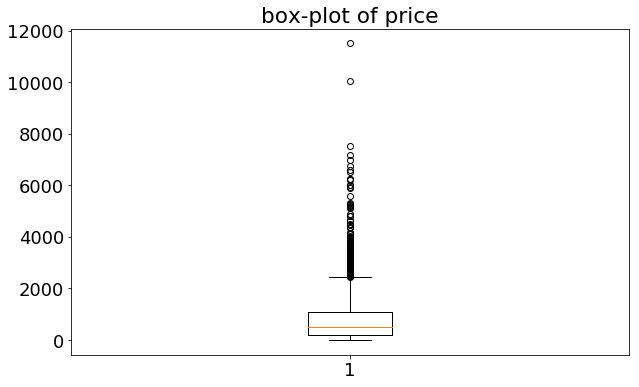

In [769]:
# extracting the lower and upper limit from box plot to remove the outliers 
plt.title("box-plot of price")
price_bxplot=plt.boxplot(x=raw_data['price'])
[item.get_ydata() for item in price_bxplot['whiskers']]


[array([24.72,  9.  ]), array([35.2675, 51.07  ])]

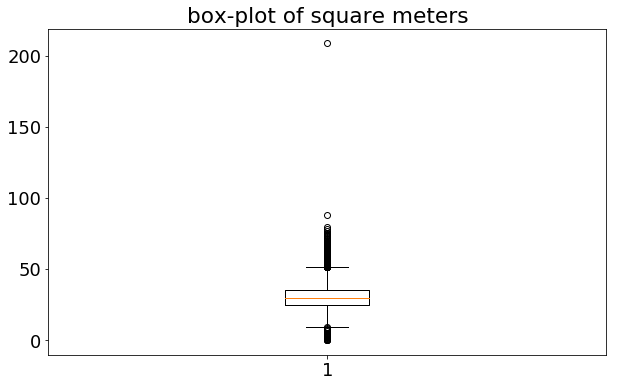

In [770]:
# extracting the lower and upper limit from box plot to remove the extreme outliers in square meters
plt.title("box-plot of square meters")
meters_bxplot=plt.boxplot(x=raw_data['square_meters'])
[item.get_ydata() for item in meters_bxplot['whiskers']]


**Price Outliers**<br>
Let us trim the price outliers on two conditions mentioned below. Later we can keep only one based on performance.
- CONDITION 1-Trim based on box plot
- CONDITION 2-Trim by removing only 1 percent outliers from both the extremes<br>
Let us proceed with CONDITION 1 and check the behavior with CONDITION 2 as well.

**Square Meter Outliers**<br>
Extracted the outliers from box plot above and went ahead with trimming<br>

In [771]:
start_percentile_price = raw_data['price'].quantile(.01)
end_percentile_price = raw_data['price'].quantile(.99)

#CONDITION 1
data_trimmed= raw_data.loc[((raw_data['price'] > 1) & (raw_data['price'] < 2450))]

# CONDITION 2
# data_trimmed= data_trimmed.loc[((data_trimmed['price'] > start_percentile_price) & 
#                                  (data_trimmed['price'] < end_percentile_price))]

data_trimmed= data_trimmed.loc[((data_trimmed['square_meters'] < 80)&(data_trimmed['square_meters'] > 2))]

final_df=data_trimmed.copy()

### DATA EXPLORATION

Text(0,0.5,'Mean Price')

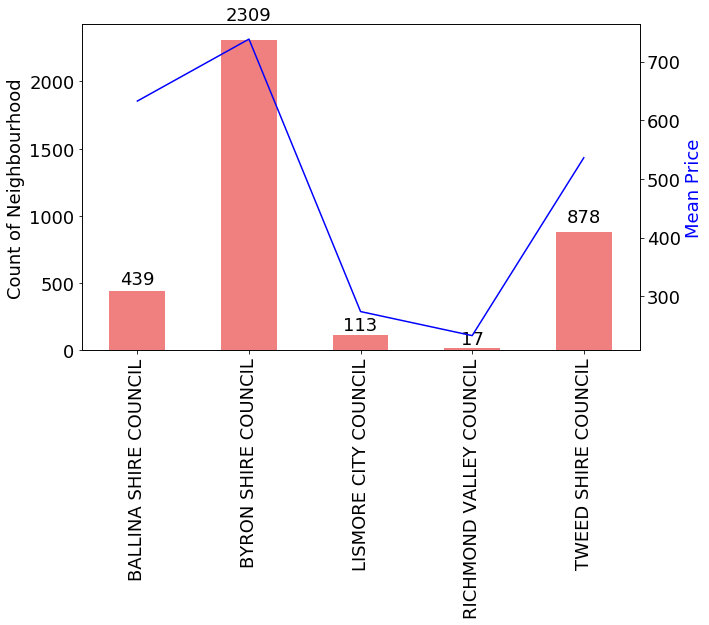

In [772]:
#The reason of adding sort_index, so that x-axis is same for both the plots
ax=final_df['neighbourhood_cleansed'].value_counts().sort_index().plot(kind='bar',color='lightcoral')


rects=ax.patches
def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')
autolabel(rects)

m=final_df.groupby(['neighbourhood_cleansed']).mean()['price']
m=m.reset_index(level=['neighbourhood_cleansed'])
x_axis=m['neighbourhood_cleansed']
y_axis=m['price']

ax2 = ax.twinx()
ax2.plot(x_axis,y_axis, 'b-')

ax.set_ylabel('Count of Neighbourhood')
ax2.set_ylabel('Mean Price', color='b')


Text(0,0.5,'Mean Price')

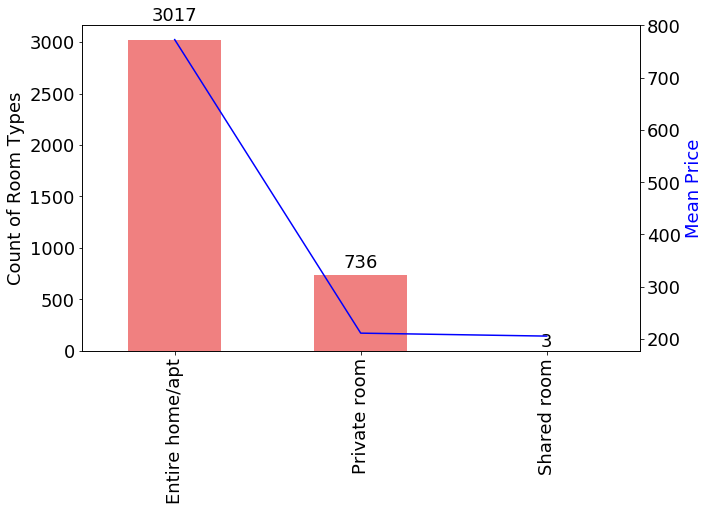

In [773]:
ax=final_df['room_type'].value_counts().sort_index().plot(kind='bar',color='lightcoral')

rects=ax.patches
def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects)

m=final_df.groupby(['room_type']).mean()['price']
m=m.reset_index(level=['room_type'])
x_axis=m['room_type']
y_axis=m['price']

ax2 = ax.twinx()
ax2.plot(x_axis,y_axis, 'b-')

ax.set_ylabel('Count of Room Types')
ax2.set_ylabel('Mean Price', color='b')

Text(0,0.5,'Mean Price')

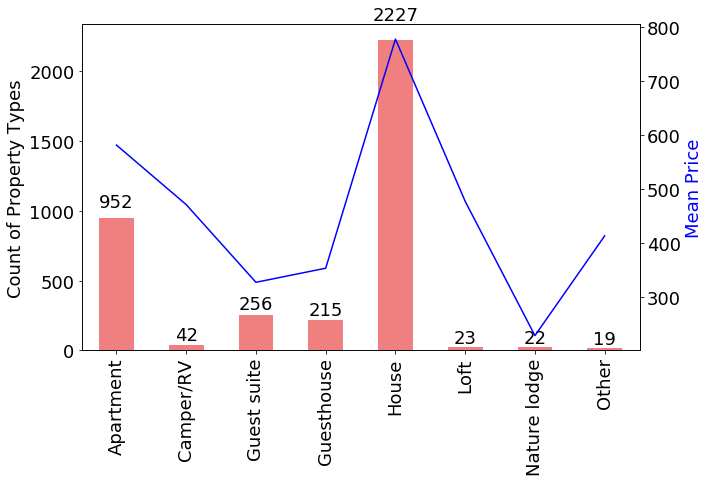

In [774]:
ax=final_df['property_type'].value_counts().sort_index().plot(kind='bar',color='lightcoral')


rects=ax.patches
def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects)

m=final_df.groupby(['property_type']).mean()['price']
m=m.reset_index(level=['property_type'])
x_axis=m['property_type']
y_axis=m['price']

ax2 = ax.twinx()
ax2.plot(x_axis,y_axis, 'b-')

ax.set_ylabel('Count of Property Types')
ax2.set_ylabel('Mean Price', color='b')

### REGRESSION ANALYSIS


**Takeaways from the three plots above**

- The analysis will be done neighborhood wise.
- Next filtration will be on room type as the prices vary based on room types and will select top 2 categories as the count of shared categories is only 3.

### BYRON SHIRE COUNCIL

In [780]:
final_df2=final_df.loc[(final_df['neighbourhood_cleansed'].isin(['BYRON SHIRE COUNCIL']))]
final_df2=final_df2.loc[(final_df2['room_type'].isin(['Entire home/apt']))]

final_df2[['neighbourhood_cleansed','room_type']].describe();

(0, 2500)

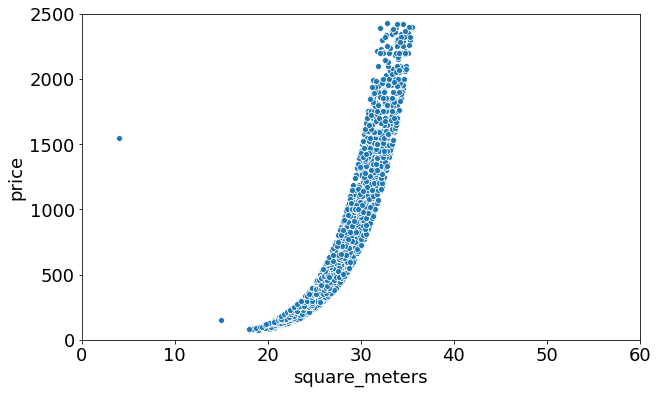

In [781]:
ax = sns.scatterplot(x = 'square_meters', y = 'price', data = final_df2)
plt.xlim([0,60])
plt.ylim([0,2500])

From the graph, we can see that the square meters less than 18 are outliers, let us remove them for this neighborhood analysis

In [782]:
final_df2= final_df2.loc[(final_df2['square_meters'] >18)]

From the above plot, it is clear that the graph is exponential of the form  $$f(x) = a{e^{bx}}$$ <br>
If we take log on both sides, then we can change the equation to linear<br>

$$log(price) = log(a{e^{b*square meters}})$$ <br>
$$log(price) = log(a) + loge(b*area)$$ <br>
$$log(price) = log(a) + b*area$$ <br>

So, taking logarithmic values of y will give us a linear equation if the model is linearly dependent.$$y=log(price)$$


In [787]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# X_cols = ['square_meters','bedrooms','bathrooms']
X_cols=['square_meters']

#Load the X data set
X = final_df2[X_cols].values

#Initialize the data and column length variables
data_length = len(final_df2)
column_length = len(final_df2[X_cols].columns)

#Reshape and load remaining data sets
X = X.reshape(data_length,column_length)
y = np.log(final_df2['price'].values)
y = y.reshape(data_length,1)

#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y)


#Create the linear regression object and train/fit models
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

#Make predictions using the testing set
listing_y_pred = lin_reg.predict(X_test)

In [788]:
#Print a few predictions
print((pd.DataFrame(listing_y_pred, columns={'y_prediction'}).head(5)))
print()

#Print the intercept
print('Intercept:', float(lin_reg.intercept_))

#Print the coefficient(s)
coeff_df = pd.DataFrame(lin_reg.coef_)
coeff_df.columns = X_cols
print(coeff_df)
print()

#Performance Metric: Mean Squared Error
print("Mean Squared Error (MSE):%.2f" % mean_squared_error(y_test, listing_y_pred))

# Explained variance score:
print('Variance Score (R^2):%.2f' % r2_score(y_test, listing_y_pred))

   y_prediction
0      7.233967
1      6.975270
2      5.396259
3      5.973058
4      6.340983

Intercept: 1.0750587785070698
   square_meters
0       0.191628

Mean Squared Error (MSE):0.05
Variance Score (R^2):0.93


Also, checked by taking the features bathrooms and bedrooms but the weight of the coefficients were very less and also no change in R2 and MSE

The model parameters are good, lets look at residuals

Text(0.5,1,'Histogram of Residuals')

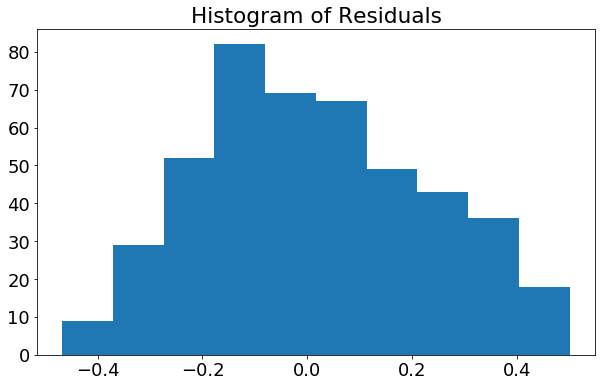

In [789]:
residuals=y_test-listing_y_pred
plt.hist(residuals)
plt.title("Histogram of Residuals")

I tried to improve the normality of residuals by removing more outliers by plotting box-plot and re-ran the code.
Let me also check the normality from a Q-Q plot.

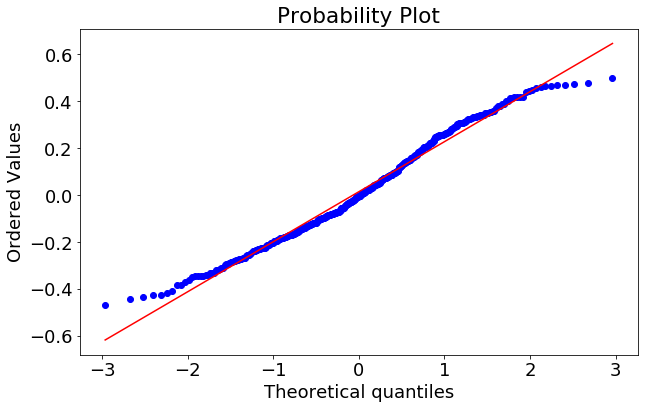

In [790]:
import numpy as np 
import pylab 
import scipy.stats as stats
residues_reshaped=residuals.reshape(-1,)
  
stats.probplot(residues_reshaped, dist="norm", plot=pylab)
pylab.show()

Text(0.5,1,'BYRON SHIRE COUNCIL')

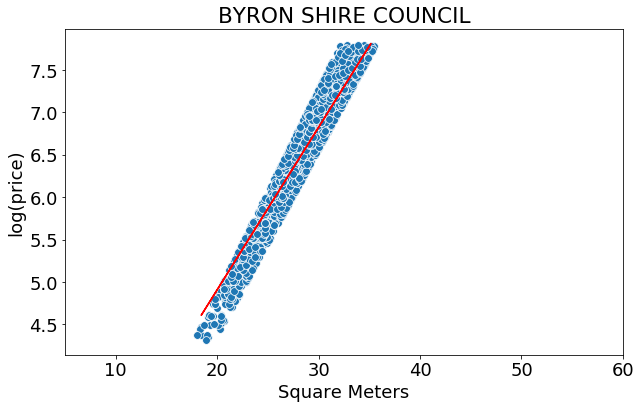

In [797]:
log_y=np.log(final_df2['price'])
ax = sns.scatterplot(x = final_df2['square_meters'], y = log_y ,s=60)
plt.plot(X_test, listing_y_pred, color='red')
plt.xlim([5,60])
plt.xlabel("Square Meters")
plt.ylabel("log(price)")
plt.title("BYRON SHIRE COUNCIL")
# plt.ylim([10,3000])


#### REGULARIZATION

Even though the model is pretty good, but still I wanted to check if I can further increase its R2 or decrease MSE with different alpha values

Mean Squared Error (MSE):0.05
Variance Score (R^2):0.93
Mean Squared Error (MSE):0.05
Variance Score (R^2):0.93
Mean Squared Error (MSE):0.14
Variance Score (R^2):0.79
Mean Squared Error (MSE):0.21
Variance Score (R^2):0.68
Mean Squared Error (MSE):0.57
Variance Score (R^2):0.15
Mean Squared Error (MSE):0.64
Variance Score (R^2):0.03
Mean Squared Error (MSE):0.65
Variance Score (R^2):0.01


Text(0,0.5,'log(price)')

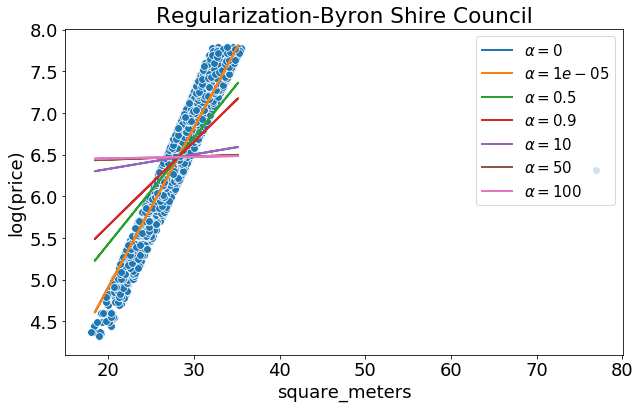

In [812]:
from sklearn.linear_model import Ridge

for alpha in [0,10**-5,0.5,0.9,10,50,100]:
    ridgeReg=Ridge(alpha=alpha,normalize=True)
    ridgeReg.fit(X_train,y_train)

    listing_y_pred=ridgeReg.predict(X_test)
    

    print("Mean Squared Error (MSE):%.2f" % mean_squared_error(y_test, listing_y_pred))


    print('Variance Score (R^2):%.2f' % r2_score(y_test, listing_y_pred))
    
    plt.plot(X_test, listing_y_pred, linewidth=2, label=r"$\alpha = {}$".format(alpha))
ax = sns.scatterplot(x = final_df2['square_meters'], y = log_y ,s=60)
plt.legend(loc="upper right", fontsize=15)
plt.title("Regularization-Byron Shire Council")
plt.ylabel("log(price)")

**We can see that model performs best when alpha=0, which is nothing but a OLS model**

### BALLINA SHIRE COUNCIL

In [886]:
final_df2=final_df.loc[(final_df['neighbourhood_cleansed'].isin(['BALLINA SHIRE COUNCIL']))]
final_df2=final_df2.loc[(final_df2['room_type'].isin(['Entire home/apt']))]

final_df2[['neighbourhood_cleansed','room_type']].describe();

(0, 3000)

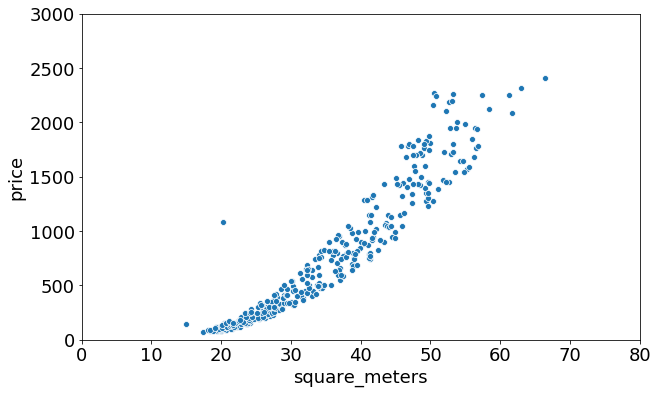

In [887]:
ax = sns.scatterplot(x = 'square_meters', y = 'price', data = final_df2)
plt.xlim([0,80])
plt.ylim([0,3000])

From the above plot, we can see there are two outliers. Let us remove the visible outliers. 

In [888]:
final_df2=final_df2.drop(final_df2[(final_df2.square_meters < 30) & (final_df2.price > 800)].index)
final_df2=final_df2.drop(final_df2[(final_df2.square_meters < 17)].index)        

In [895]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

X_cols = ['square_meters']

#Load the X data set
X = final_df2[X_cols].values

#Initialize the data and column length variables
data_length = len(final_df2)
column_length = len(final_df2[X_cols].columns)

#Reshape and load remaining data sets
X = X.reshape(data_length,column_length)
y = final_df2['price'].values
y = y.reshape(data_length,1)

#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y)


#Create the linear regression object and train/fit models
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

#Make predictions using the testing set
listing_y_pred = lin_reg.predict(X_test)

In [896]:
#Print a few predictions
print((pd.DataFrame(listing_y_pred, columns={'y_prediction'}).head(5)))
print()

#Print the intercept
print('Intercept:', float(lin_reg.intercept_))

#Print the coefficient(s)
coeff_df = pd.DataFrame(lin_reg.coef_)
coeff_df.columns = X_cols
print(coeff_df)
print()

#Performance Metric: Mean Squared Error
print("Mean Squared Error (MSE):%.2f" % mean_squared_error(y_test, listing_y_pred))

# Explained variance score:
print('Variance Score (R^2):%.2f' % r2_score(y_test, listing_y_pred))

   y_prediction
0    717.398198
1    610.714739
2    192.348233
3   1512.817518
4    711.122701

Intercept: -1065.8890338077385
   square_meters
0      52.295813

Mean Squared Error (MSE):21395.76
Variance Score (R^2):0.92


Text(0.5,1,'Histogram of Residuals')

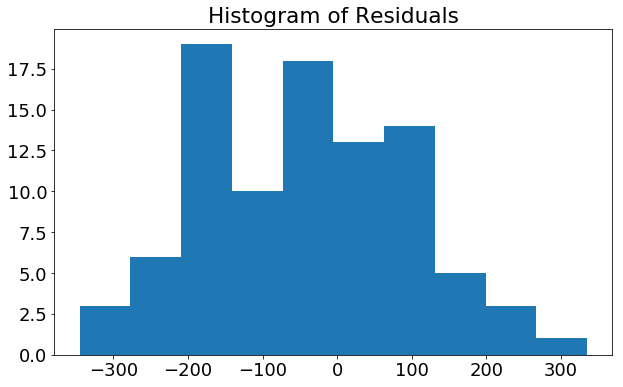

In [897]:
residuals=y_test-listing_y_pred
plt.hist(residuals)
plt.title("Histogram of Residuals")

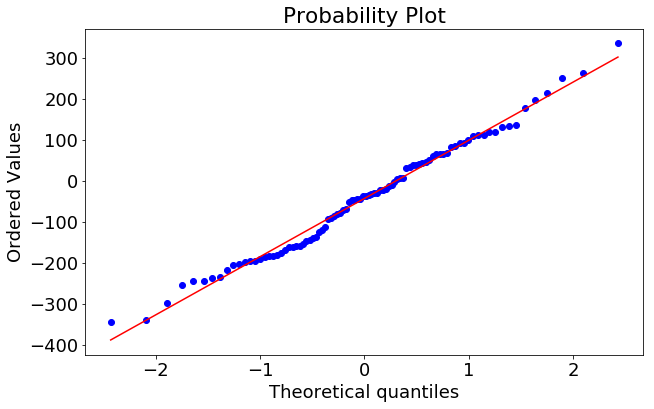

In [898]:
import numpy as np 
import pylab 
import scipy.stats as stats
residues_reshaped=residuals.reshape(-1,)
  
stats.probplot(residues_reshaped, dist="norm", plot=pylab)
pylab.show()

Text(0.5,1,'BALLINA SHIRE COUNCIL')

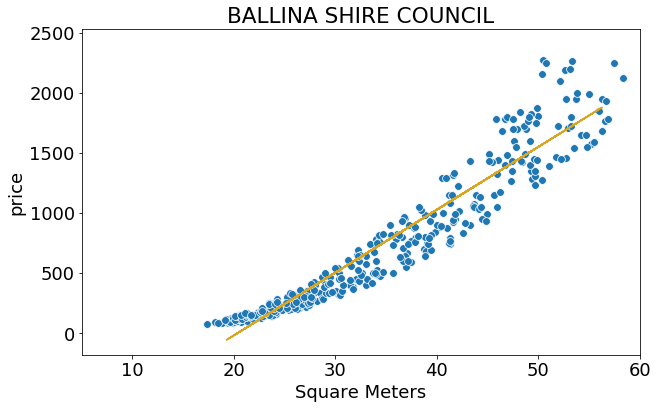

In [899]:
log_y=final_df2['price']
ax = sns.scatterplot(x = final_df2['square_meters'], y = log_y ,s=60)
plt.plot(X_test, listing_y_pred, color='goldenrod')
plt.xlim([5,60])
plt.xlabel("Square Meters")
plt.ylabel("price")
plt.title("BALLINA SHIRE COUNCIL")

#### REGULARIZATION

Checking R2 and MSE with different alpha values

Mean Squared Error (MSE):21395.76
Variance Score (R^2):0.92
Mean Squared Error (MSE):21395.38
Variance Score (R^2):0.92
Mean Squared Error (MSE):21054.78
Variance Score (R^2):0.92
Mean Squared Error (MSE):20426.44
Variance Score (R^2):0.92
Mean Squared Error (MSE):41558.96
Variance Score (R^2):0.85
Mean Squared Error (MSE):266888.87
Variance Score (R^2):0.01


Text(0.5,1,'Regularization-Ballina Shire Council')

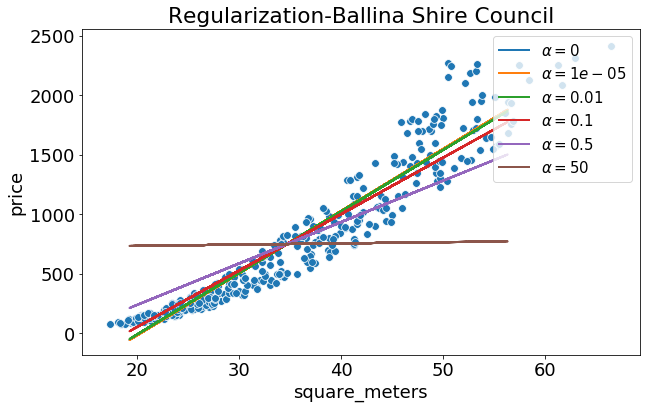

In [910]:
from sklearn.linear_model import Ridge

for alpha in [0,10**-5,10**-2,10**-1,0.5,50]:
    ridgeReg=Ridge(alpha=alpha,normalize=True)
    ridgeReg.fit(X_train,y_train)

    listing_y_pred=ridgeReg.predict(X_test)
    

    print("Mean Squared Error (MSE):%.2f" % mean_squared_error(y_test, listing_y_pred))


    print('Variance Score (R^2):%.2f' % r2_score(y_test, listing_y_pred))
    
    plt.plot(X_test, listing_y_pred, linewidth=2, label=r"$\alpha = {}$".format(alpha))
ax = sns.scatterplot(x = final_df2['square_meters'], y = log_y ,s=60)
plt.legend(loc="upper right", fontsize=15)
plt.title("Regularization-Ballina Shire Council")

We can see that with alpha=0.1, MSE reduced by 1500 without any change to R2. So, after regularization, our new coefficients are-

In [911]:
ridgeReg=Ridge(alpha=0.1,normalize=True)
ridgeReg.fit(X_train,y_train)
listing_y_pred=ridgeReg.predict(X_test)

print(ridgeReg.coef_)
print(ridgeReg.intercept_)

[[47.54164841]]
[-900.93317123]


I can see that the weight of the coefficient is also reduced

### TWEED SHIRE COUNCIL

In [913]:
final_df2=final_df.loc[(final_df['neighbourhood_cleansed'].isin(['TWEED SHIRE COUNCIL']))]
final_df2=final_df2.loc[(final_df2['room_type'].isin(['Entire home/apt']))]

final_df2[['neighbourhood_cleansed','room_type']].describe();

Before moving ahead with Tweed Shire Analysis, I did some initial analysis and got a horizontal parabola with the equation of the form 
$$x = a{y^{2}}+by+c$$
$$squaremeters = a{(price)^{2}}+b(price)+c$$

To change the curve from horizontal to vertical, I changed the x to price and y to square meters. The reason I did this way because I wanted to have an equation in the form of f(x) rather than f(y)
$$y = a{x^{2}}+bx+c$$


(0, 3000)

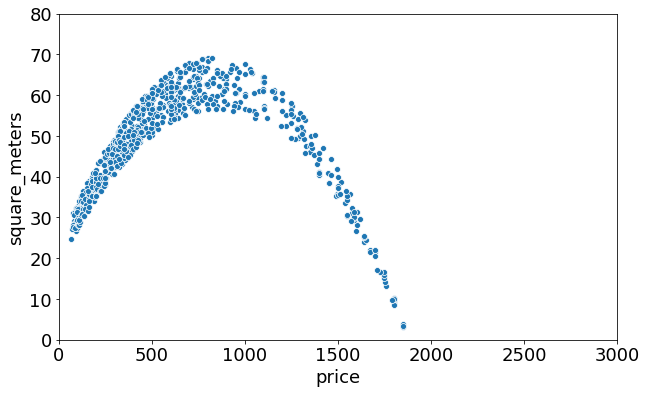

In [914]:
ax = sns.scatterplot(x = 'price', y = 'square_meters', data = final_df2)
plt.ylim([0,80])
plt.xlim([0,3000])

After some Google search, I found that quadratic equations can be solved by Numpy's *polyfit()*. It gives good result with lower order polynomials. Let us proceed by fitting it with *Train* values and test our results with *test* values. <br>



In [915]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

X_cols = ['price']

#Load the X data set
X = final_df2[X_cols].values

#Initialize the data and column length variables
data_length = len(final_df2)
column_length = len(final_df2[X_cols].columns)

#Reshape and load remaining data sets
X = X.reshape(data_length,column_length)
y = final_df2['square_meters'].values
y = y.reshape(data_length,1)

#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y)

y_train=y_train.reshape(-1,)
X_train=X_train.reshape(-1,)
z = np.polyfit(X_train, y_train, 2)
z

array([-5.93950770e-05,  1.00115999e-01,  2.11516416e+01])

Thus, we get three coefficients. Let us predict square meters with the below mentioned equation and see our model performance. If this model performs good, we can use eq(1) to predict price.

$$squaremeters = (a *{price}^{2}) + (b* price) + c$$ <br>
$$(a *{price}^{2}) + (b* price) + (c-squaremeters)=0$$
$$price=\frac{-b+_-\sqrt{b^2-4a(c-squaremeters)}}{2a}------eq(1)$$

In [916]:
# prediction of y values based on X_test
X_test=X_test.reshape(-1,)
listing_y_pred=[]
for i in range(len(y_test)):
    p=z[0]*((X_test[i])**2)+(z[1]*X_test[i])+z[2] 
    listing_y_pred.append(p)

In [917]:
listing_y_pred=np.asarray(listing_y_pred)
y_test=y_test.reshape(-1,);
y_test.shape;

Text(0.5,1,'Histogram of Residuals')

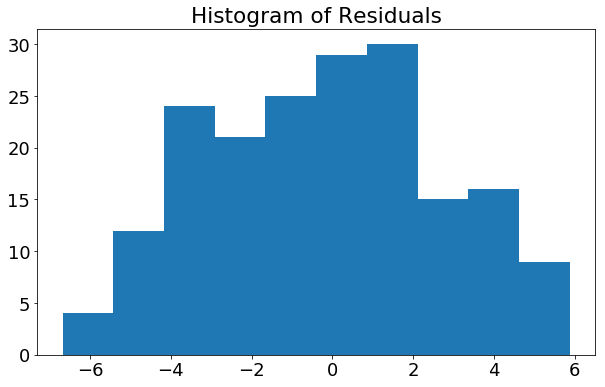

In [918]:
residuals=y_test-listing_y_pred
plt.hist(residuals)
plt.title("Histogram of Residuals")

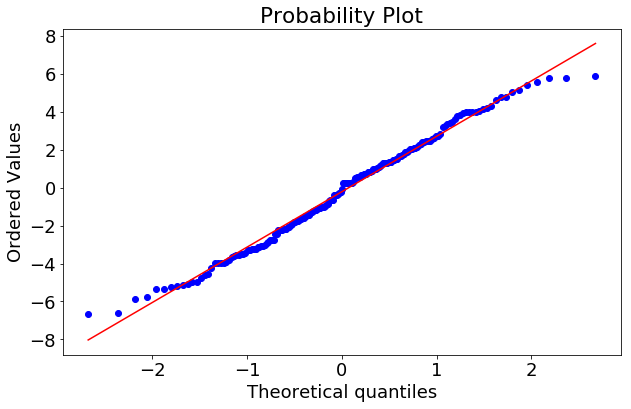

In [919]:
import numpy as np 
import pylab 
import scipy.stats as stats
residues_reshaped=residuals.reshape(-1,)
  
stats.probplot(residues_reshaped, dist="norm", plot=pylab)
pylab.show()

In [920]:
#Performance Metric: Mean Squared Error
print("Mean Squared Error (MSE):%.2f" % mean_squared_error(y_test, listing_y_pred))

# Explained variance score:
# print('Variance Score (R^2):%.2f' % r2_score(y_test, listing_y_pred))

Mean Squared Error (MSE):8.46


Text(0.5,1,'TWEED SHIRE COUNCIL')

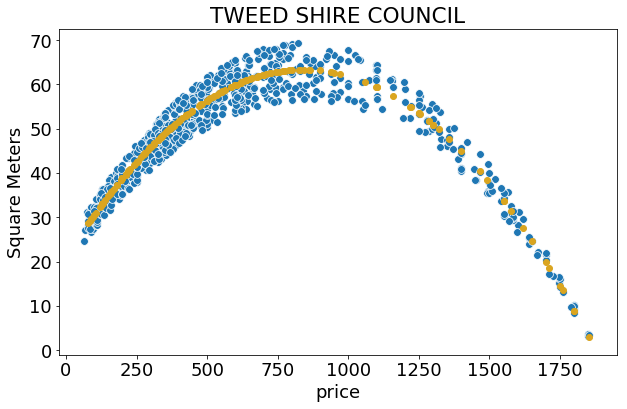

In [921]:
y=final_df2['square_meters']
ax = sns.scatterplot(x = final_df2['price'], y=y ,s=60)
plt.scatter(x=X_test, y=listing_y_pred, color='goldenrod')
# plt.xlim([5,70])
plt.ylabel("Square Meters")
plt.xlabel("price")
plt.title("TWEED SHIRE COUNCIL")

#### REGULARIZATION

This is a polynomial function with degree 2. Let us check its performance with different alpha values

In [925]:
y_train=y_train.reshape(-1,1)
X_train=X_train.reshape(-1,1)
y_test=y_test.reshape(-1,1)
X_test=X_test.reshape(-1,1)

for alpha in [0,10**-5,10**-2,0.5,10,50,100]:
    steps = [
        ('scalar', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2)),
        ('model', Ridge(alpha=alpha, fit_intercept=True))
        ]

    ridge_pipe = Pipeline(steps)
    ridge_pipe.fit(X_train, y_train)
    print(f"For alpha={alpha}")
    print('Training Score: {}'.format(ridge_pipe.score(X_train, y_train)))
    print('Test Score: {}'.format(ridge_pipe.score(X_test, y_test))) 

For alpha=0
Training Score: 0.9428026634008261
Test Score: 0.9481792930120595
For alpha=1e-05
Training Score: 0.9428026634008249
Test Score: 0.9481792928756716
For alpha=0.01
Training Score: 0.9428026620651532
Test Score: 0.9481791553383979
For alpha=0.5
Training Score: 0.9427993386494773
Test Score: 0.9481692699514881
For alpha=10
Training Score: 0.9415776231256505
Test Score: 0.9468624478304446
For alpha=50
Training Score: 0.9203930530328035
Test Score: 0.9259027483778532
For alpha=100
Training Score: 0.8784259820663525
Test Score: 0.8847796203400273


** We can see that with alpha=0, the model performs best which is nothing but a OLS model**

### LISMORE CITY COUNCIL

In [954]:
final_df2=final_df[(final_df['neighbourhood_cleansed'].isin(['LISMORE CITY COUNCIL']))]
final_df2=final_df2.loc[(final_df2['room_type'].isin(['Entire home/apt']))]

final_df2[['neighbourhood_cleansed','room_type']].describe();

(0, 3000)

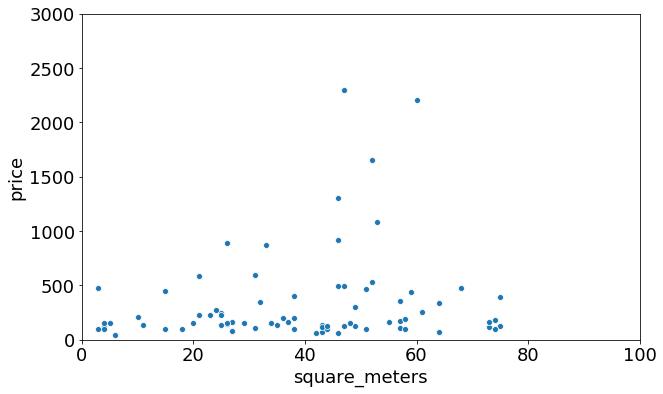

In [955]:
ax = sns.scatterplot(x = 'square_meters', y = 'price', data = final_df2)
plt.xlim([0,100])
plt.ylim([0,3000])

Let us remove outliers visible from the above graph. (Please note that I tried the above with the dataset which contained all the outliers, but there was no improvement)

(0, 1000)

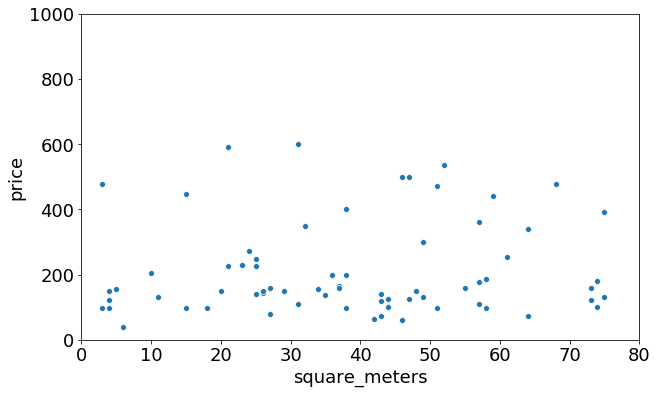

In [956]:
final_df2= final_df2.loc[((final_df2['price'] < 700))]
ax = sns.scatterplot(x = 'square_meters', y = 'price', data = final_df2)
plt.xlim([0,80])
plt.ylim([0,1000])

We can see that the plot is random and there is no pattern. Let us proceed with linear regression.

In [957]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

X_cols = ['square_meters']

#Load the X data set
X = final_df2[X_cols].values

#Initialize the data and column length variables
data_length = len(final_df2)
column_length = len(final_df2[X_cols].columns)

#Reshape and load remaining data sets
X = X.reshape(data_length,column_length)
y = final_df2['price'].values
y = y.reshape(data_length,1)

#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y)


#Create the linear regression object and train/fit models
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

#Make predictions using the testing set
listing_y_pred = lin_reg.predict(X_test)

In [958]:
#Print a few predictions
print((pd.DataFrame(listing_y_pred, columns={'y_prediction'}).head(5)))
print()

#Print the intercept
print('Intercept:', float(lin_reg.intercept_))

#Print the coefficient(s)
coeff_df = pd.DataFrame(lin_reg.coef_)
coeff_df.columns = X_cols
print(coeff_df)
print()

#Performance Metric: Mean Squared Error
print("Mean Squared Error (MSE):%.2f" % mean_squared_error(y_test, listing_y_pred))

# Explained variance score:
print('Variance Score (R^2):%.2f' % r2_score(y_test, listing_y_pred))

   y_prediction
0    240.515830
1    215.011784
2    248.277931
3    209.467426
4    226.100500

Intercept: 177.3101508525068
   square_meters
0       1.108872

Mean Squared Error (MSE):16350.73
Variance Score (R^2):-0.17


The model is pretty bad, we cannot accept this model

Text(0.5,1,'LISMORE CITY COUNCIL')

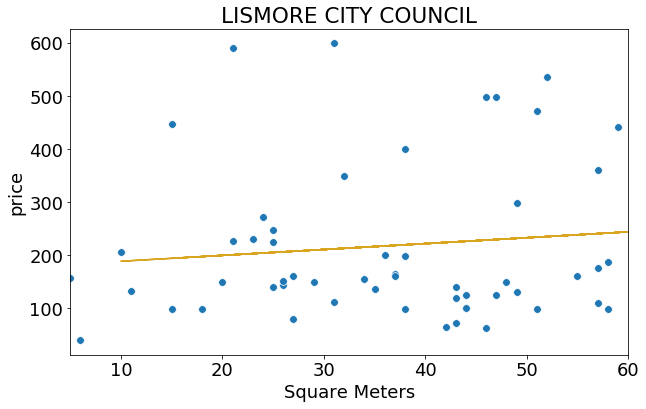

In [959]:
y=final_df2['price']
ax = sns.scatterplot(x = final_df2['square_meters'], y = y ,s=60)
plt.plot(X_test, listing_y_pred, color='goldenrod')
plt.xlim([5,60])
plt.xlabel("Square Meters")
plt.ylabel("price")
plt.title("LISMORE CITY COUNCIL")

Let us apply regularization both with linear and polynomial and see if there is any change in the performance

For alpha=0
Training Score: 0.02325331931018282
Test Score: -0.16982046399654616
Mean Squared Error (MSE):16350.73
For alpha=10
Training Score: 0.02325331444184997
Test Score: -0.1697609839537324
Mean Squared Error (MSE):16349.90
For alpha=100
Training Score: 0.023252836461845394
Test Score: -0.16922867689841747
Mean Squared Error (MSE):16342.46
For alpha=0
Training Score: 0.3161872001893432
Test Score: -1.1358620907984451
Mean Squared Error (MSE):29853.21
For alpha=1e-05
Training Score: 0.14465675977209969
Test Score: -0.8352603923419635
Mean Squared Error (MSE):25651.67
For alpha=100
Training Score: 0.023743031250479163
Test Score: -0.11513874136542168
Mean Squared Error (MSE):15586.44


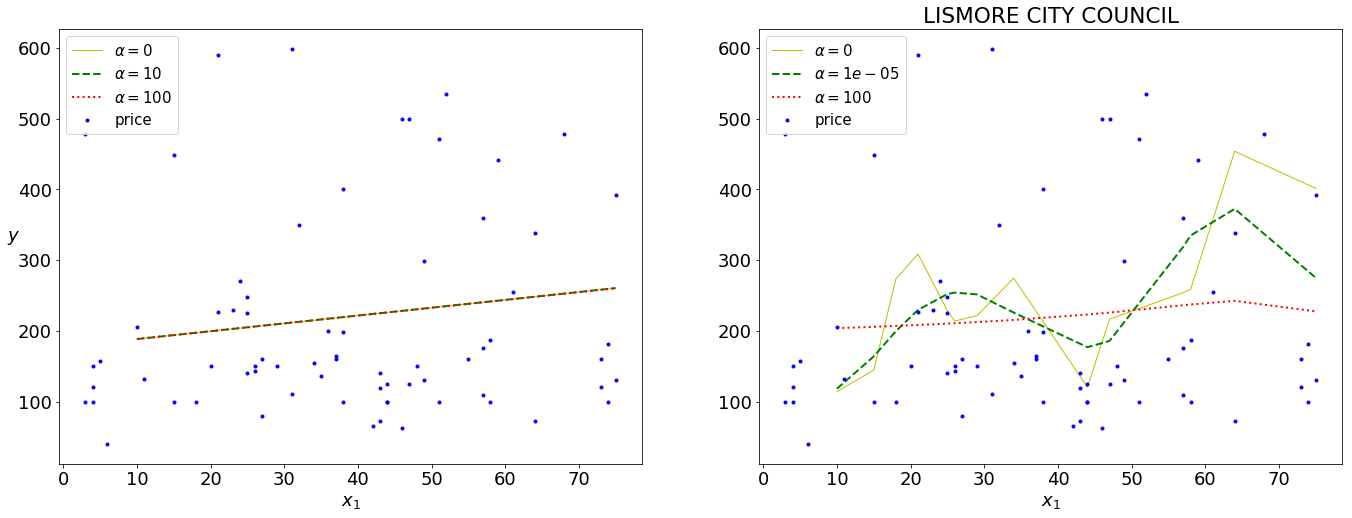

In [960]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("y-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=15, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X_train, y_train)
        y_new_regul = model.predict(X_test)


        lw = 2 if alpha > 0 else 1
        new_x, new_y = zip(*sorted(zip(X_test, y_new_regul)))
        plt.plot(new_x, new_y, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
        print(f"For alpha={alpha}")
        print('Training Score: {}'.format(model.score(X_train, y_train)))
        print('Test Score: {}'.format(model.score(X_test, y_test)))
        print("Mean Squared Error (MSE):%.2f" % mean_squared_error(y_test, y_new_regul))
        
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)


plt.figure(figsize=(23,8))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5,100), random_state=42)
plt.title("LISMORE CITY COUNCIL")
plt.show()

We can see that there is no improvement. I tried with different degrees to fit a polynomial curve but was not successful.

### RICHMOND VALLEY COUNCIL

In [961]:
final_df2=final_df.loc[(final_df['neighbourhood_cleansed'].isin(['RICHMOND VALLEY COUNCIL']))]
final_df2=final_df2.loc[(final_df2['room_type'].isin(['Entire home/apt']))]

final_df2[['neighbourhood_cleansed','room_type']].describe();

(0, 3000)

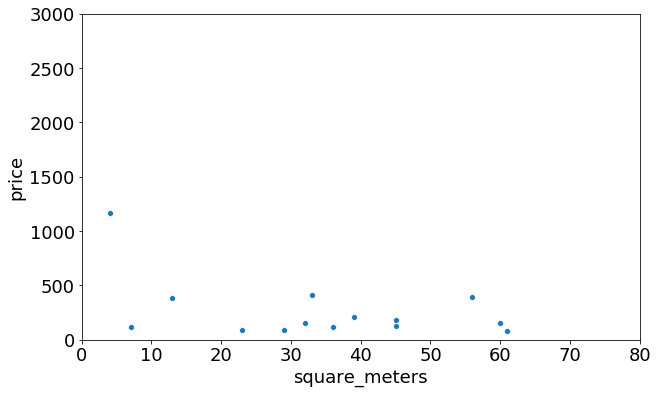

In [962]:
ax = sns.scatterplot(x = 'square_meters', y = 'price', data = final_df2 )
plt.xlim([0,80])
plt.ylim([0,3000])


I also tried the graph with the dataframe which contained outliers, but no improvement in the pattern. Let us remove the visible outlier.

(0, 1000)

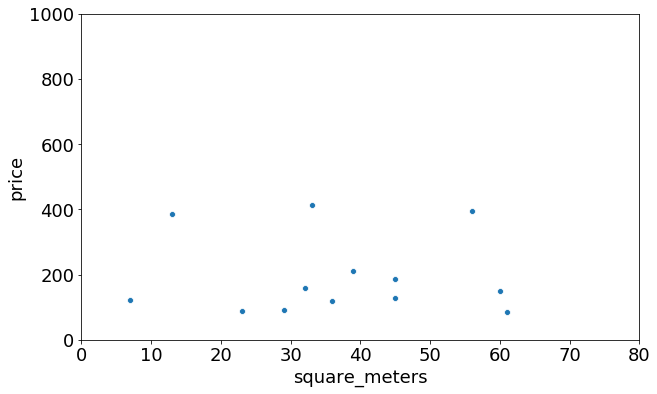

In [963]:
final_df2= final_df2.loc[((final_df2['price'] < 1000))]
ax = sns.scatterplot(x = 'square_meters', y = 'price', data = final_df2)
plt.xlim([0,80])
plt.ylim([0,1000])

The plot is random and there is no pattern. So, moving ahead with linear regression.

In [964]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

X_cols = ['square_meters']

#Load the X data set
X = final_df2[X_cols].values

#Initialize the data and column length variables
data_length = len(final_df2)
column_length = len(final_df2[X_cols].columns)

#Reshape and load remaining data sets
X = X.reshape(data_length,column_length)
y = final_df2['price'].values
y = y.reshape(data_length,1)

#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y)


#Create the linear regression object and train/fit models
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

#Make predictions using the testing set
listing_y_pred = lin_reg.predict(X_test)

In [965]:
#Print a few predictions
print((pd.DataFrame(listing_y_pred, columns={'y_prediction'}).head(5)))
print()

#Print the intercept
print('Intercept:', float(lin_reg.intercept_))

#Print the coefficient(s)
coeff_df = pd.DataFrame(lin_reg.coef_)
coeff_df.columns = X_cols
print(coeff_df)
print()

#Performance Metric: Mean Squared Error
print("Mean Squared Error (MSE):%.2f" % mean_squared_error(y_test, listing_y_pred))

# Explained variance score:
print('Variance Score (R^2):%.2f' % r2_score(y_test, listing_y_pred))

   y_prediction
0    200.315805
1    196.957336
2    201.435295
3    229.422539

Intercept: 237.25896784283066
   square_meters
0       -1.11949

Mean Squared Error (MSE):16323.62
Variance Score (R^2):-0.08


It is evident that, we cannot accept the model

Text(0.5,1,'RICHMOND VALLEY COUNCIL')

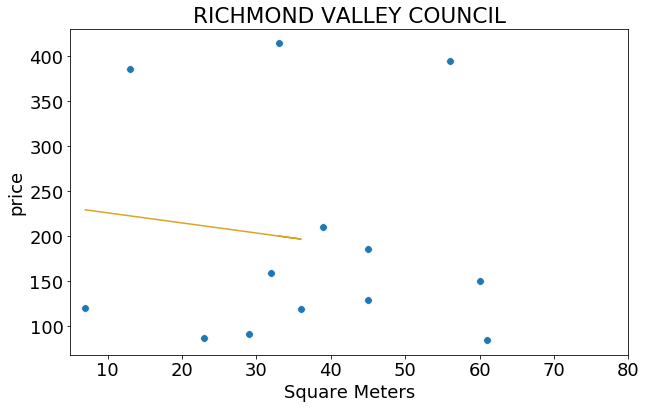

In [966]:
log_y=final_df2['price']
ax = sns.scatterplot(x = final_df2['square_meters'], y = log_y ,s=60)
plt.plot(X_test, listing_y_pred, color='goldenrod')
plt.xlim([5,80])
plt.xlabel("Square Meters")
plt.ylabel("price")
plt.title("RICHMOND VALLEY COUNCIL")

Let us apply regularization both with linear and polynomial and see if there is any change in the performance

For alpha=0
Training Score: 0.024269434669230924
Test Score: -0.08396423564365074
Mean Squared Error (MSE):16323.62
For alpha=10
Training Score: 0.02426896925838873
Test Score: -0.08351683551316391
Mean Squared Error (MSE):16316.88
For alpha=100
Training Score: 0.024226356140986227
Test Score: -0.07970458809065706
Mean Squared Error (MSE):16259.47
For alpha=0
Training Score: 0.8973520658999521
Test Score: -55.41810231348088
Mean Squared Error (MSE):849610.78
For alpha=1e-05
Training Score: 0.7389895442517682
Test Score: -4.478570419119797
Mean Squared Error (MSE):82502.82
For alpha=100
Training Score: 0.00527528225798235
Test Score: -0.013114791026386241
Mean Squared Error (MSE):15256.69


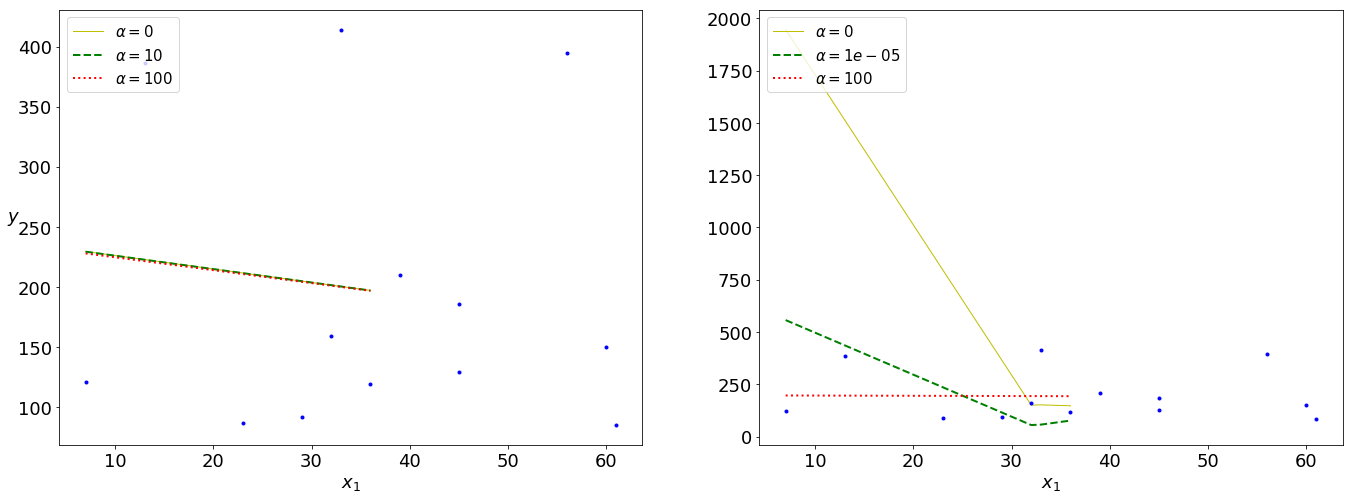

In [972]:
def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("y-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=5, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X_train, y_train)
        y_new_regul = model.predict(X_test)


        lw = 2 if alpha > 0 else 1
        new_x, new_y = zip(*sorted(zip(X_test, y_new_regul)))
        plt.plot(new_x, new_y, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
        print(f"For alpha={alpha}")
        print('Training Score: {}'.format(model.score(X_train, y_train)))
        print('Test Score: {}'.format(model.score(X_test, y_test)))
        print("Mean Squared Error (MSE):%.2f" % mean_squared_error(y_test, y_new_regul))
        
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)


plt.figure(figsize=(23,8))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5,100), random_state=42)
plt.show()

Even after trying different alpha and  degree to fit polynomial curve, the performance of the model did not improve.

### INFERENCES

### EDA

- The top three expensive neighbourhoods are- Byron, Ballina and Tweed Shire Councils with approximate mean prices of 700 dollars, 600 dollars and 550 dollars. Lismore and Richmond mean prices are almost same with less than 200 dollars.
- The mean prices for private and shared rooms are less than 250 dollars, whereas for entire home, it is around 750 dollars and for apartment is 600 dollars.


### REGRESSION ANALYSIS

- Carried the regression of all the neighborhoods and ran the data both for Entire home/apt and Private rooms. No significance difference found between the room types,so  went ahead with only Entire home/apt.
- When considered bedrooms and bathrooms in the equation, the weights of the coefficient were not very high which hardly made any difference to the model equation. The analysis below is only based on square meters

| NEIGHBORHOOD | ROOM TYPE | MODEL | RESIDUALS | R2 | MSE| EQUATION | REGULARIZATION | COMMENTS |
|--------------- | ---------- | -------- | ---------- | ----------- | ----------- | ------ | ------ |
|Byron Shire Council| Entire home/apt | Exponential | only normality | 0.93 |0.05| $$log(price) \approx 1.075 + 0.192 * area $$ | No effect with Regularization | Although the performance metrics seems correct with normal residual plot but doubtful with other properties like homoscedasticity | 
|Ballina Shire Council | Entire home/apt | Linear | only normality | 0.92 | 20426.44 | $$price \approx 47.542 * area - 900.93$$| Regularized with Ridge Regression | Although the R2 seems correct with normal residual plot but doubtful with high MSE and some other properties of residuals like homoscedasticity |
|Tweed Shire Council | Entire home/apt | Quadratic | not normal | NA | 8.46 | $$price \approx \frac{-b+_-\sqrt{b^2-4a(c-squaremeters)}}{2a}$$ <br>$$a=121.15$$ <br> $$b=0.1$$<br> $$c=-5.939e-05$$ |No effect with regularization | Although the performance metrics seems correct with normal residual plot but doubtful with other properties like homoscedasticity| 
|Lismore City Council | Entire home /apt | no perfect model| none of the properties satisfied | -0.17 | 16450.73 | $$price \approx 1.108 * area + 177.31.2$$ | Tried with both polynomial & Linear, no improvement | Model not accepted |
|Richmond City Council | Entire home /apt | no perfect model|none of the properties satisfied | -0.08 | 16323.62 | $$price \approx -1.12* area + 237.26.2$$ | Tried with both polynomial & Linear, no improvement | Model not accepted |